# Deep Learning

## preprocessing training dataset

In [272]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

input_file_dir = "/Users/ninglee/Documents/IntrutionDection/datasets"
train_file_name = "kddcup.data_10_percent.txt"
test_file_name = "corrected.txt"
header_file_name = "header.txt"
train_files = os.path.join(input_file_dir, train_file_name)
test_files = os.path.join(input_file_dir, test_file_name)
header_files = os.path.join(input_file_dir, header_file_name)

In [245]:
with open(header_files, 'r') as f:
    header = f.readline().strip().split(',')
train_dataset = pd.read_csv(train_files)
test_dataset = pd.read_csv(test_files)
train_dataset.columns = header
test_dataset.columns = header

In [246]:
train_dataset_size = train_dataset.shape[0]
test_dataset_size = test_dataset.shape[0]
train_dataset = pd.concat([train_dataset, test_dataset], axis=0)
print train_dataset_size, test_dataset_size

494020 311028


In [247]:
print train_dataset.shape

(805048, 42)


In [248]:
def labels_map(label):
    label = str(label).split('.')[0]
    if label == 'normal':
        return 0
    if label in ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']: #PROBE
        return 1
    if label in ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm']: #DOS
        return 2
    if label in ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']: #U2R
        return 3
    if label in ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop']: #R2L
        return 4
    
train_dataset['labels'] = train_dataset['labels'].apply(labels_map)
labels_dummies = pd.get_dummies(train_dataset['labels'], prefix='label')
train_dataset = pd.concat([train_dataset,labels_dummies], axis=1)

In [249]:
train_dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,label_0,label_1,label_2,label_3,label_4
0,0,tcp,http,SF,239,486,0,0,0,0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
1,0,tcp,http,SF,235,1337,0,0,0,0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
2,0,tcp,http,SF,219,1337,0,0,0,0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
3,0,tcp,http,SF,217,2032,0,0,0,0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0


In [250]:
protocal_type_dummies = pd.get_dummies(train_dataset.protocol_type, prefix='protocol_type')
service_dummies = pd.get_dummies(train_dataset.service, prefix='service')
flag_dummies = pd.get_dummies(train_dataset.flag, prefix='flag')
train_dataset = pd.concat([train_dataset, protocal_type_dummies, service_dummies, flag_dummies], axis=1)

In [251]:
max1 = train_dataset.src_bytes.max(); min1 = train_dataset.src_bytes.min();
max2 = train_dataset.dst_bytes.max(); min2 = train_dataset.dst_bytes.min();
train_dataset['src_bytes_norm'] = (train_dataset.src_bytes - min1) / float(max1 - min1)
train_dataset['dst_bytes_norm'] = (train_dataset.dst_bytes - min2) / float(max2 - min2)

In [252]:
train_dataset = train_dataset.drop(['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes','labels'], axis=1)

In [253]:
train_dataset = train_dataset.astype('float')
# train_dataset = (train_dataset - train_dataset.min()) / (train_dataset.max() - train_dataset.min())

## preprocessing test dataset

In [287]:
# sub_train_dataset = train_dataset.iloc[:train_dataset_size, :].sample(n=200000)
# sub_test_dataset = train_dataset.iloc[train_dataset_size:, :].sample(n=50000)

sub_train_dataset = train_dataset.iloc[:train_dataset_size, :].sample(n=100000)
sub_test_dataset = train_dataset.iloc[train_dataset_size:, :].sample(n=100000)

sub_train_labels = sub_train_dataset[['label_0', 'label_1', 'label_2', 'label_3', 'label_4']]
sub_test_labels = sub_test_dataset[['label_0', 'label_1', 'label_2', 'label_3', 'label_4']]
sub_train_dataset.drop(['label_0', 'label_1', 'label_2', 'label_3', 'label_4'], axis=1, inplace=True)
sub_test_dataset.drop(['label_0', 'label_1', 'label_2', 'label_3', 'label_4'], axis=1, inplace=True)

ValueError: a must be greater than 0

In [255]:
test_dataset = train_dataset.iloc[train_dataset_size:,:]
train_dataset = train_dataset.iloc[:train_dataset_size, :]
train_labels = train_dataset[['label_0', 'label_1', 'label_2', 'label_3', 'label_4']]
test_labels = test_dataset[['label_0', 'label_1', 'label_2', 'label_3', 'label_4']]
train_dataset.drop(['label_0', 'label_1', 'label_2', 'label_3', 'label_4'], axis=1, inplace=True)
test_dataset.drop(['label_0', 'label_1', 'label_2', 'label_3', 'label_4'], axis=1, inplace=True)

In [256]:
print train_dataset.shape, train_labels.shape
print test_dataset.shape, test_labels.shape

(494020, 119) (494020, 5)
(311028, 119) (311028, 5)


In [257]:
print sub_train_dataset.shape, sub_train_labels.shape
print sub_test_dataset.shape, sub_test_labels.shape

(490000, 119) (490000, 5)
(310000, 119) (310000, 5)


In [258]:
sub_train_dataset.describe()
sub_train_dataset.head()

,duration,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,src_bytes_norm,dst_bytes_norm
263139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000001,0.0
211434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000001,0.0
278148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000001,0.0
380215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
46798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000001,0.0


## model1: MLP

In [259]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [280]:
batch_size = 256
feature_size = 119
num_labels = 5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, feature_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
#   tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(sub_test_dataset.values[:,:])
  
  # Variables.
  hidden_weights = tf.Variable(
    tf.truncated_normal([feature_size, 512]))
  output_weights = tf.Variable(
    tf.truncated_normal([512, num_labels]))
  weights = [hidden_weights, output_weights]
  hidden_biases = tf.Variable(tf.zeros([512]))
  output_biases = tf.Variable(tf.zeros([num_labels]))
  biases = [hidden_biases, output_biases]
  
  # Training computation.
  hidden_layer = tf.add(tf.matmul(tf_train_dataset, tf.cast(weights[0], tf.float32)), biases[0])
  hidden_layer = tf.nn.relu(hidden_layer)
#   hidden_layer = tf.nn.dropout(hidden_layer, 0.5)
  logits = tf.add(tf.matmul(hidden_layer, tf.cast(weights[1], tf.float32)), biases[1])
#   logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  l2Loss = tf.nn.l2_loss(weights[0]) + tf.nn.l2_loss(weights[1])
  loss = loss + 20*l2Loss
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(1e-3).minimize(loss)#5e-3
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  # ValidPrediction
#   temp1 = tf.add(tf.matmul(tf_valid_dataset, weights[0]), biases[0])
#   hidden_temp = tf.nn.relu(temp1)
#   temp2 = tf.add(tf.matmul(hidden_temp,weights[1]), biases[1])
#   valid_prediction = tf.nn.softmax(temp2)

  # TestPrediction
  temp3 = tf.add(tf.matmul(tf.cast(tf_test_dataset, tf.float32), weights[0]), biases[0])
  hidden_temp2 = tf.nn.relu(temp3)
  temp4 = tf.add(tf.matmul(tf.cast(hidden_temp2, tf.float32), weights[1]), biases[1])
  test_prediction = tf.nn.softmax(temp4)

In [285]:
num_steps = 6001
loss_history = []
train_acc_history = []
test_acc_history = []
with tf.Session(graph=graph) as session:
  #tf.initialize_all_variables().run()
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (sub_train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = sub_train_dataset.iloc[offset:(offset + batch_size), :].values[:,:]
    batch_labels = sub_train_labels.iloc[offset:(offset + batch_size), :].values[:,:]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    #record
    first_it = (step == 0)
    last_it = (step == num_steps - 1)
    loss_history.append(l);
    if first_it or last_it or (step % 300 == 0) or (step < 10):
        train_acc_history.append(accuracy(predictions, batch_labels))
        test_acc_history.append(accuracy(test_prediction.eval(), sub_test_labels.values[:,:]))
        
    if (step % 300 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_acc_history[-1])
#       print("Validation accuracy: %.1f%%" % accuracy(
#         valid_prediction.eval(), valid_labels))
      print("Test accuracy: %.1f%%" % test_acc_history[-1])

Initialized
Minibatch loss at step 0: 502613.687500
Minibatch accuracy: 0.4%
Test accuracy: 73.9%
Minibatch loss at step 300: 3.114267
Minibatch accuracy: 96.5%
Test accuracy: 89.8%
Minibatch loss at step 600: 0.489133
Minibatch accuracy: 97.7%
Test accuracy: 89.8%
Minibatch loss at step 900: 0.540780
Minibatch accuracy: 96.5%
Test accuracy: 89.8%
Minibatch loss at step 1200: 0.521162
Minibatch accuracy: 96.9%
Test accuracy: 89.8%
Minibatch loss at step 1500: 0.542130
Minibatch accuracy: 98.0%
Test accuracy: 89.9%
Minibatch loss at step 1800: 0.487588
Minibatch accuracy: 98.0%
Test accuracy: 89.9%
Minibatch loss at step 2100: 0.526067
Minibatch accuracy: 96.1%
Test accuracy: 89.9%
Minibatch loss at step 2400: 0.505511
Minibatch accuracy: 98.4%
Test accuracy: 89.8%
Minibatch loss at step 2700: 0.538732
Minibatch accuracy: 96.1%
Test accuracy: 89.9%
Minibatch loss at step 3000: 0.451294
Minibatch accuracy: 99.2%
Test accuracy: 89.9%


KeyboardInterrupt: 

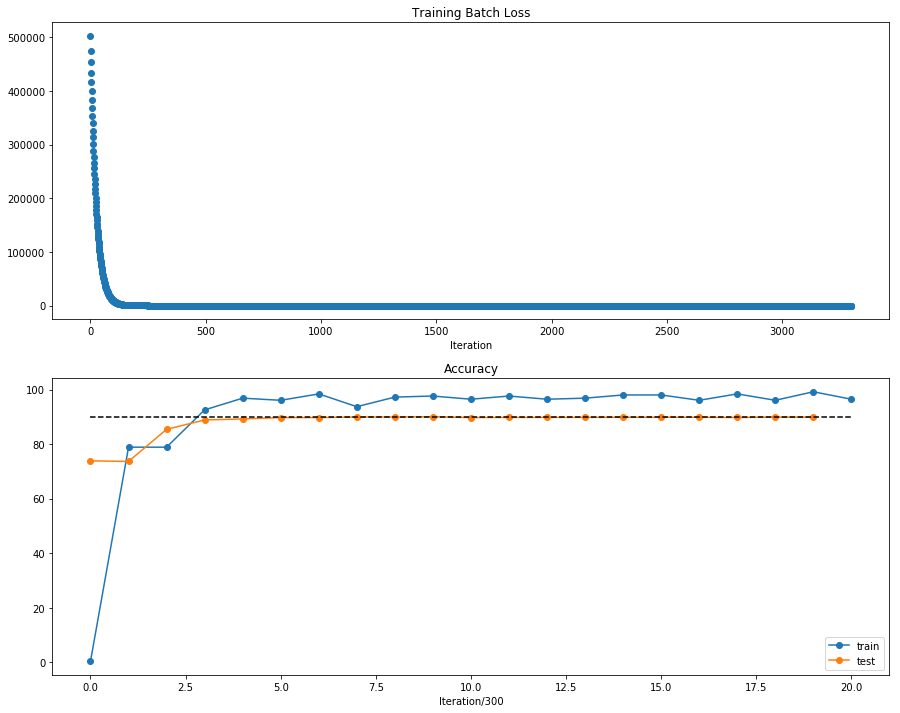

In [286]:
# plot the loss
plt.subplot(2,1,1)
plt.title('Training Batch Loss')
plt.plot(loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(train_acc_history, '-o', label='train')
plt.plot(test_acc_history, '-o', label='test')
plt.plot([90] * len(train_acc_history), 'k--')
plt.xlabel('Iteration/300')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15,12)
plt.show()